In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.lines as mlines

from tqdm import tqdm

In [34]:
def circle_param(x0, y0, r, phi0, vel=1):
    def f(t):
        return x0 + r * np.cos(t * vel + phi0), y0 + r * np.sin(t * vel + phi0)
    return f

def ellipse_param(x0, y0, a, b, phi0, vel=1):
    def f(t):
        return x0 + a * np.cos(t * vel + phi0), y0 + b * np.sin(t * vel + phi0)
    return f

def lissajous_param(x0, y0, A, B, a, b, phi0, T0, vel=1):
    def f(t):
        return x0 + A * np.sin((t + T0) * vel * a + phi0), y0 + B * np.sin((t + T0) * vel * b)
    return f

In [35]:
def calc_acc(t, m, G):
    acc = np.zeros_like(t)
    for b1 in range(t.shape[0]):
        for b2 in range(b1+1, t.shape[0]):
            norms = np.linalg.norm(t[b1] - t[b2], axis=1) ** 3
            a = G * (t[b1] - t[b2]) / norms[:,None]
            acc[b1] -= m[b2] * a
            acc[b2] += m[b1] * a
    return acc

def build_analytical_trajectory(t, m, G, dt, *, k=1):
    # leapfrog
    res = np.zeros((t.shape[0], int(t.shape[1]*k), t.shape[2]))
    vel = np.zeros((t.shape[0], int(t.shape[1]*k), t.shape[2]))
    acc = np.zeros((t.shape[0], int(t.shape[1]*k), t.shape[2]))
    res[:, 0:2] = t[:, 0:2]
    vel[:, 0] = (res[:, 1] - res[:, 0]) / dt
    acc[:, 0:1, :] = calc_acc(res[:, 0:1, :], m, G)
    
    for j in range(1, res.shape[1]-1):
        acc[:, j:j+1, :] = calc_acc(res[:, j:j+1, :], m, G)
        vel[:, j] = vel[:, j-1] + acc[:, j] * dt
        res[:, j+1] = res[:, j] + vel[:, j] * dt
    return res

In [36]:
def calc_loss(t, m, G, dt):
    a = build_analytical_trajectory(t, m, G, dt, k=1)
    return np.sum(np.linalg.norm(a - t, axis=2)) / (t.shape[0] * t.shape[1] * dt)

In [37]:
def relaxation(t, m, G, dt, *, N, hist_period, dumping_coef=1, filename):    
    plt.gcf().clear()
    plt.title("Start trajectories")
    for b in range(t.shape[0]):
        plt.plot(*zip(*t[b]))
        plt.scatter(*t[b, 0])
    plt.axis('equal')
    plt.show()
    
    t_tmp = np.zeros_like(t)
    t_hist = np.zeros((N // hist_period, t.shape[0], t.shape[1], t.shape[2]))
    loss_hist = np.zeros((N // hist_period,))
    patience = 30
    for i in tqdm(range(N)):
        acc = dt**2 / 2 * calc_acc(t, m, G)
        for b in range(t.shape[0]):
            t_tmp[b] = (np.append(t[b, -1:], t[b, :-1], axis=0) + np.append(t[b, 1:], t[b, :1], axis=0))/2 - acc[b]

        
        if i % hist_period == 0:
            t_hist[i // hist_period] = t
            loss_hist[i // hist_period] = calc_loss(t, m, G, dt)
            if loss_hist[i // hist_period] - loss_hist[i // hist_period - 1] > -1e-3:
                patience -= 1
            else:
                patience = 20
            if patience == 0:
                print('Relaxation converged, stopping...')
                print('Final loss:', loss_hist[i // hist_period])
                break
            if np.max(t) > 1000 or np.min(t) < -1000:
                print('Relaxation diverged, stopping...')
                break 
            
        t = (t_tmp + dumping_coef * t) / (1 + dumping_coef)
    
    plt.title('Final trajectories')
    for b in range(t.shape[0]):
        plt.plot(*zip(*t_hist[i // hist_period, b]))
        plt.scatter(*t_hist[i // hist_period, b, 0])

    plt.axis('equal')
    plt.show()
    
    return t_hist[:i // hist_period + 1], loss_hist[:i // hist_period + 1]

In [38]:
def animate_hist(t_hist, m, G, dt, *, k=5, limits=(-10, 10, -10, 10), title=''):
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.axis(limits)
    l = [ax.plot([], [])[0] for _ in range(len(m))]
    l[0].set_label('current trajectory')
    analytical_l = [ax.plot([], [], linestyle=':')[0] for _ in range(len(m))]
    analytical_l[0].set_label('analytical trajectory')
    s = [ax.scatter([], []) for _ in range(len(m))]


    def animate(i):
        ax.set_title(title + ' (iteration, ' + str(i) + ')' if title else 'Iteration, ' + str(i))
        a = build_analytical_trajectory(t_hist[i], m, G, dt, k=k)
        for b in range(len(m)):
            l[b].set_data(*zip(*t_hist[i, b]))
            analytical_l[b].set_data(*zip(*a[b]))
            s[b].set_offsets(t_hist[i, b, 0])
        ax.legend(loc=1)

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=t_hist.shape[0])
    return ani

def animate_t(t, m, k=1, title=''):
    fig, ax = plt.subplots()
    ax.axis('equal')
    plt.title(title)

    for b in range(len(m)):
        ax.plot(*zip(*t[b]))
    s = [ax.scatter([], [], label='m: ' + str(m[b])) for b in range(len(m))]
    cm = ax.scatter([], [], label='center of mass')
    plt.legend()

    def animate(i):
        for b in range(len(m)):
            s[b].set_offsets(t[b, i*k])
        cm_offset = np.array([0, 0], dtype='float')
        for b in range(len(m)):
            cm_offset += m[b] * t[b, i*k]
        cm.set_offsets(cm_offset / np.sum(m))
        return (*s), cm

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=t.shape[1]//k, blit=True)
    return ani

In [42]:
def run_experiment(*, starting_parametric_curves, masses, G, dt, N, T=2*np.pi, filename, dumping_coef=0.1):
    ts = np.arange(0, T, dt)
    t = np.zeros((len(starting_parametric_curves), ts.shape[0], 2))
    for p in range(len(starting_parametric_curves)):
        t[p] = np.array(starting_parametric_curves[p](ts)).T
        
    animate_t(t, masses, k=ts.shape[0]//50, title='Starting trajectories').save('images/' + filename + '_start.gif', writer='imagemagick', fps=20)   
    
    t_hist, loss_hist = relaxation(t, masses, G, dt, N=N, hist_period=N//100, dumping_coef=dumping_coef, filename=filename)
    
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.semilogy(loss_hist)
    plt.show()
    
    ani1 = animate_hist(t_hist, masses, G, dt, title='Minimization process')
    ani2 = animate_t(t_hist[-1], masses, k=ts.shape[0]//50, title='Final trajectories')
    print("Generating gifs...")
    ani1.save('images/' + filename + '_evolution.gif', writer='imagemagick', fps=10)
    ani2.save('images/' + filename + '.gif', writer='imagemagick', fps=20)    

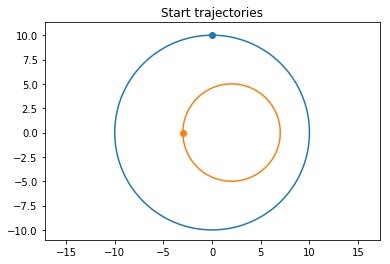

 47%|████▋     | 14020/30000 [00:01<00:02, 7428.28it/s]


Relaxation converged, stopping...
Final loss: 0.06296577391125627


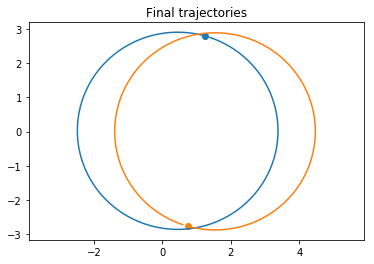

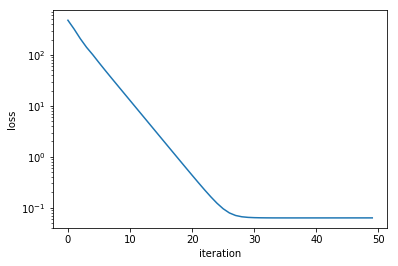

Generating gifs...


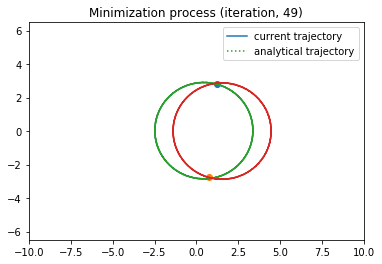

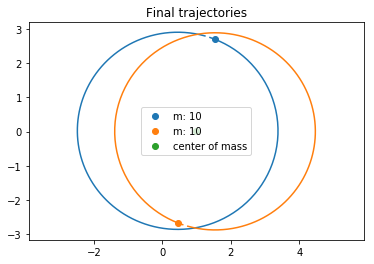

In [43]:
run_experiment(
    starting_parametric_curves=[
        circle_param(0, 0, 10, np.pi/2),
        circle_param(2, 0, 5, np.pi)
    ],
    masses=[10, 10],
    G=10,
    dt=0.05,
    N=30000,
    filename='2-bodies'
)

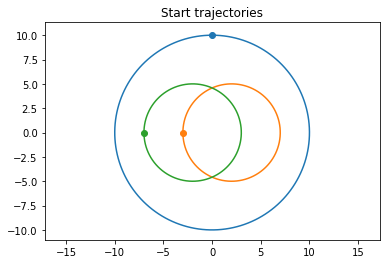

100%|██████████| 1000000/1000000 [05:12<00:00, 3196.27it/s]


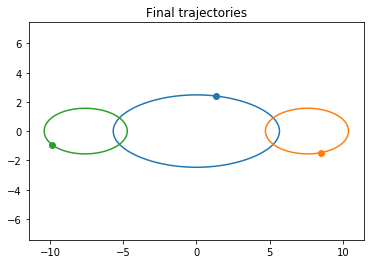

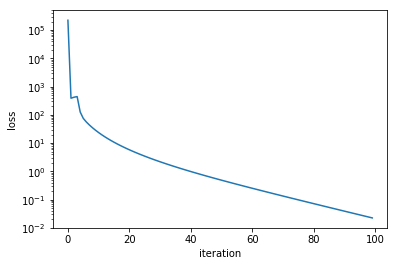

Generating gifs...


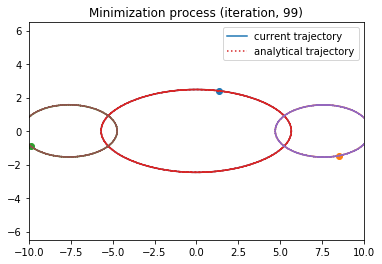

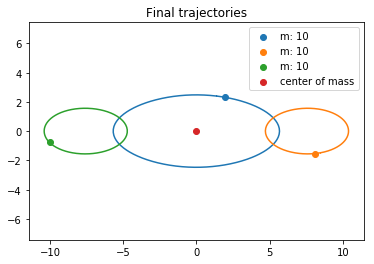

In [44]:
run_experiment(
    starting_parametric_curves=[
        circle_param(0, 0, 10, np.pi/2),
        circle_param(2, 0, 5, np.pi),
        circle_param(-2, 0, 5, np.pi),
    ],
    masses=[10, 10, 10],
    G=10,
    dt=0.02,
    N=1000000,
    filename='3-bodies-oval'
)

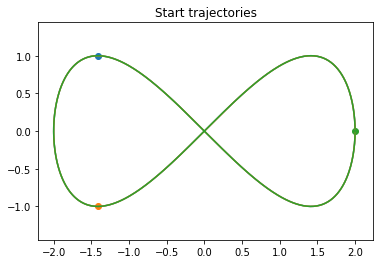

100%|██████████| 200000/200000 [01:41<00:00, 1970.90it/s]


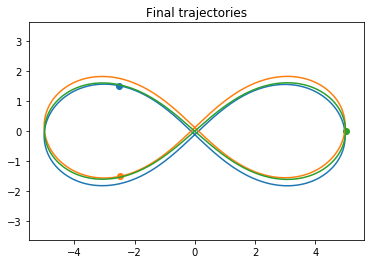

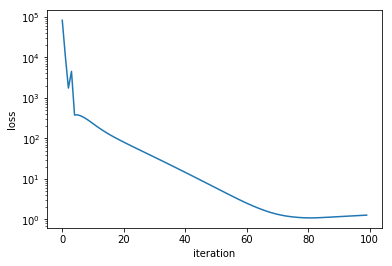

Generating gifs...


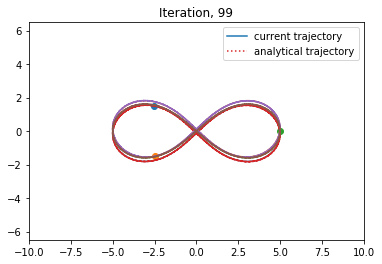

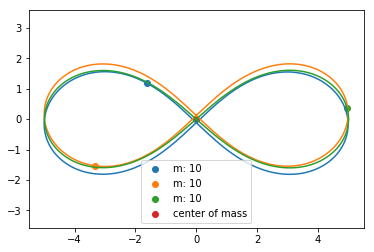

In [29]:
run_experiment(
    starting_parametric_curves=[
        lissajous_param(0, 0, 2, 1, 1, 2, 0, -np.pi*3/4),
        lissajous_param(0, 0, 2, 1, 1, 2, 0, -np.pi/4),
        lissajous_param(0, 0, 2, 1, 1, 2, 0, +np.pi/2),
    ],
    masses=[10, 10, 10],
    G=10,
    dt=0.01,
    N=200000,
    filename='3-bodies-eight'
)
